## 1. Project Overview
Using SQL Server as the primary database and Power BI for visualization, the project showcases how raw, unreliable data can be converted into trustworthy information suitable for reporting and decision-making

## 2. Business Problem
Organizations frequently rely on customer data to drive strategic and operational decisions. However, when datasets contain duplicates, missing values, and inconsistent formats, analytical results become unreliable and can lead to incorrect conclusions.

## 3. Data Source
- **Dataset Name:** *(Global_Freelancers_Dataset)*  
- **Source:** *(Kaggle)*  
- **Format:** CSV  
- **Rows / Columns:** 1000 rows / 12 columns  
- **Some Main Fields:**  
`freelancer_ID`, `name`, `rating`, `client_satisfaction`, etc.

## 4. Database Setup (SQL Server)
**Database created:** `Freelancers_Data_Base`

**Steps:**
1. Created schema/DataBase;
    * Cleaning
    * Freelancers_Data_Base
2. Imported the CSV into SQL Server Management Studio (SSMS). (as Global_Freelancers_Dataset)
3. Create user;
    * usr_data_cleaning & usr_tableau_viewer

###1. Create schema/DataBase

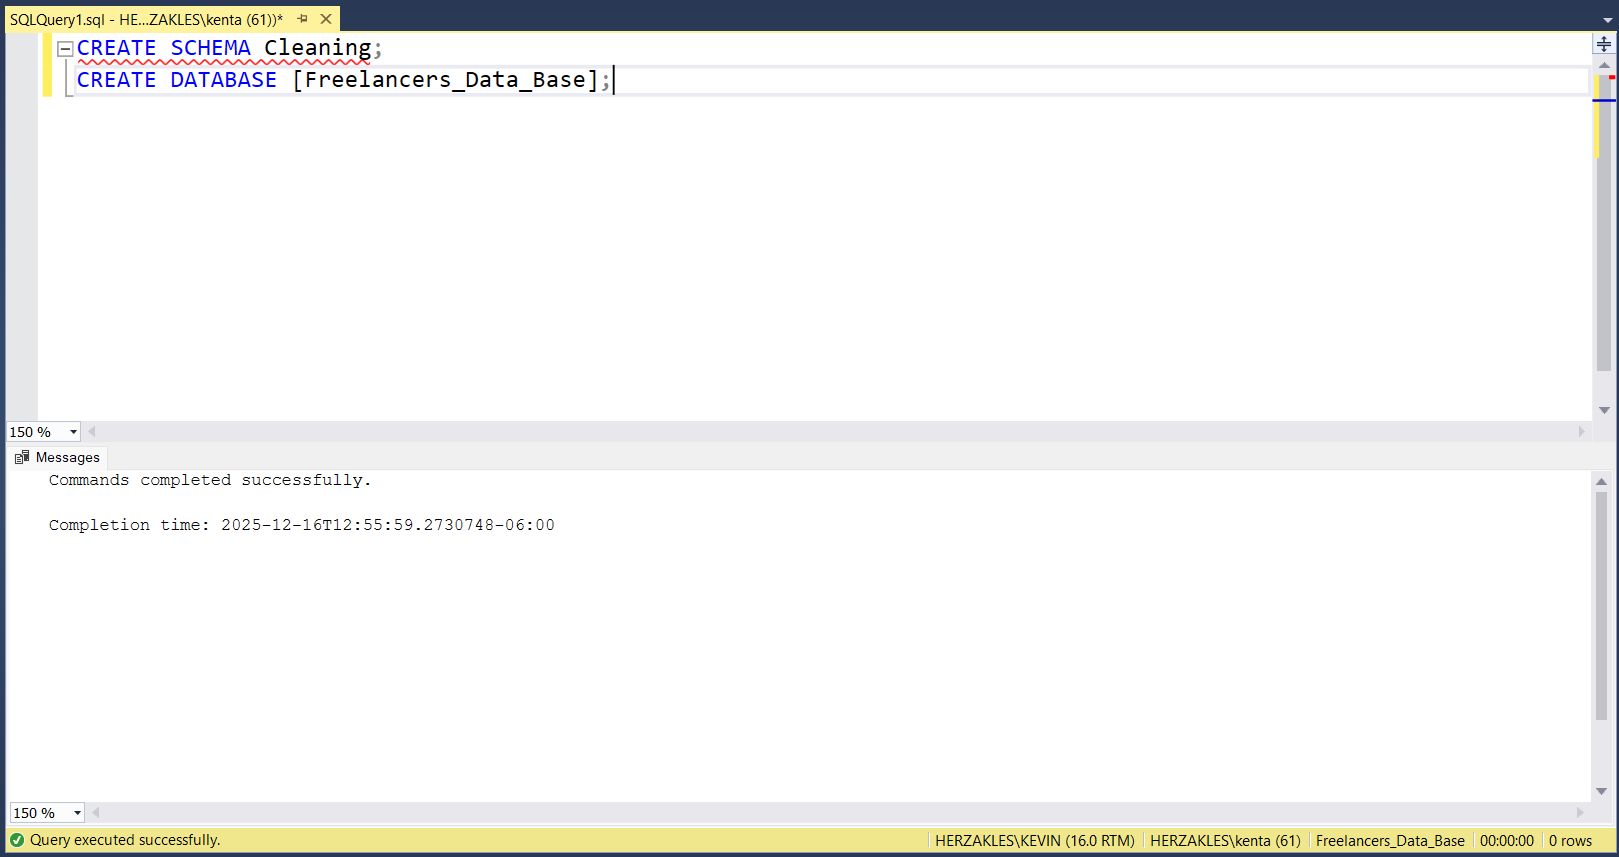

###2. Import the CSV
(here a SELECT just to show .csv is already on SSMS)

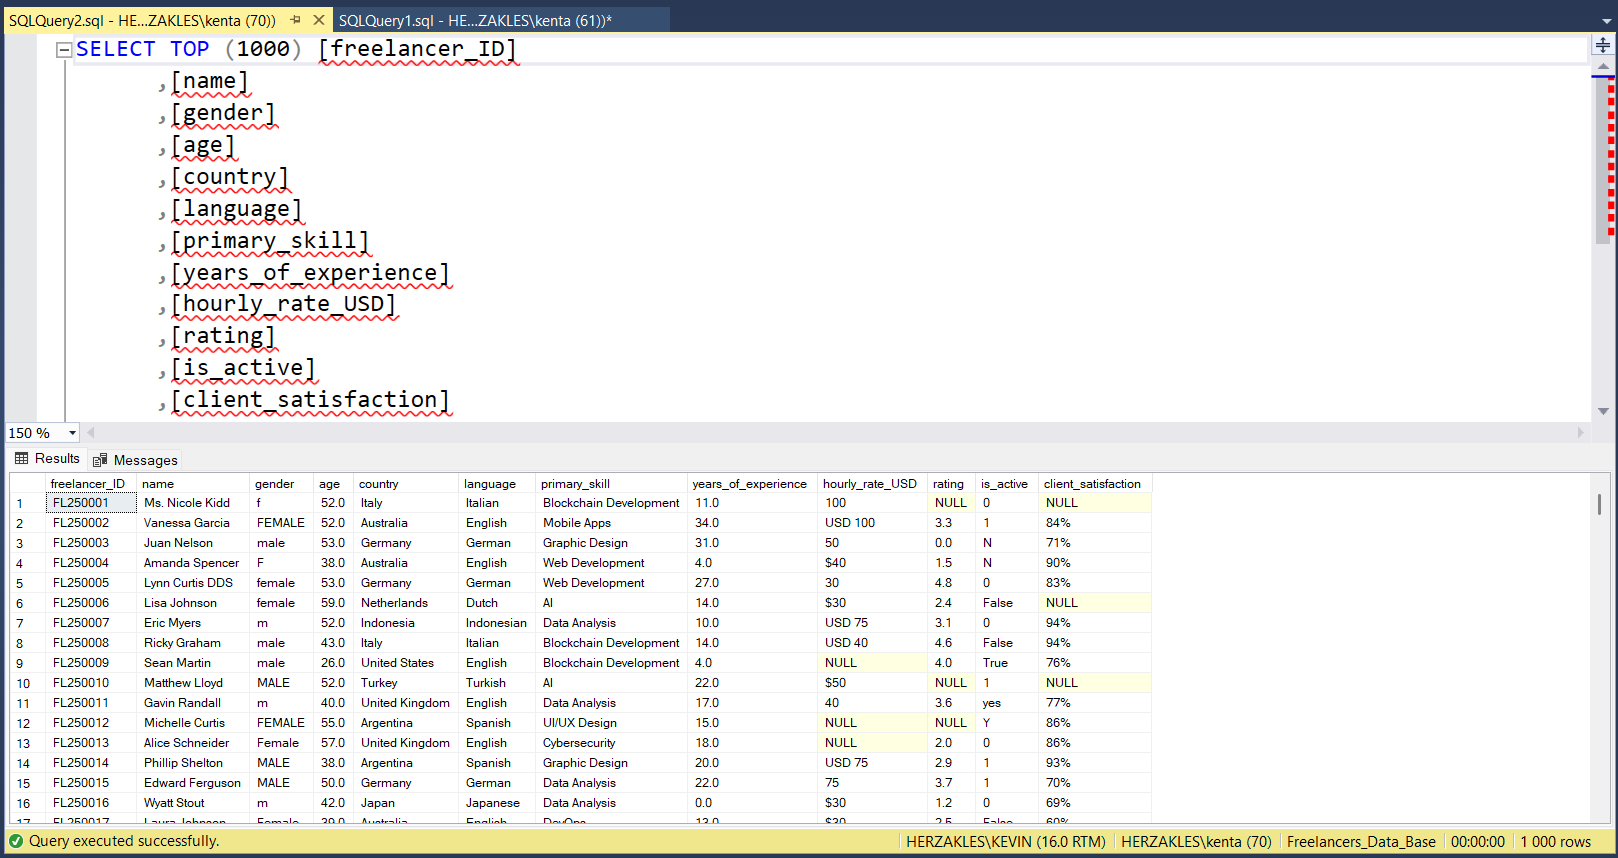

###3. Create users
(Just to have a better simulation of how it is to be on a real workflow enviroment)

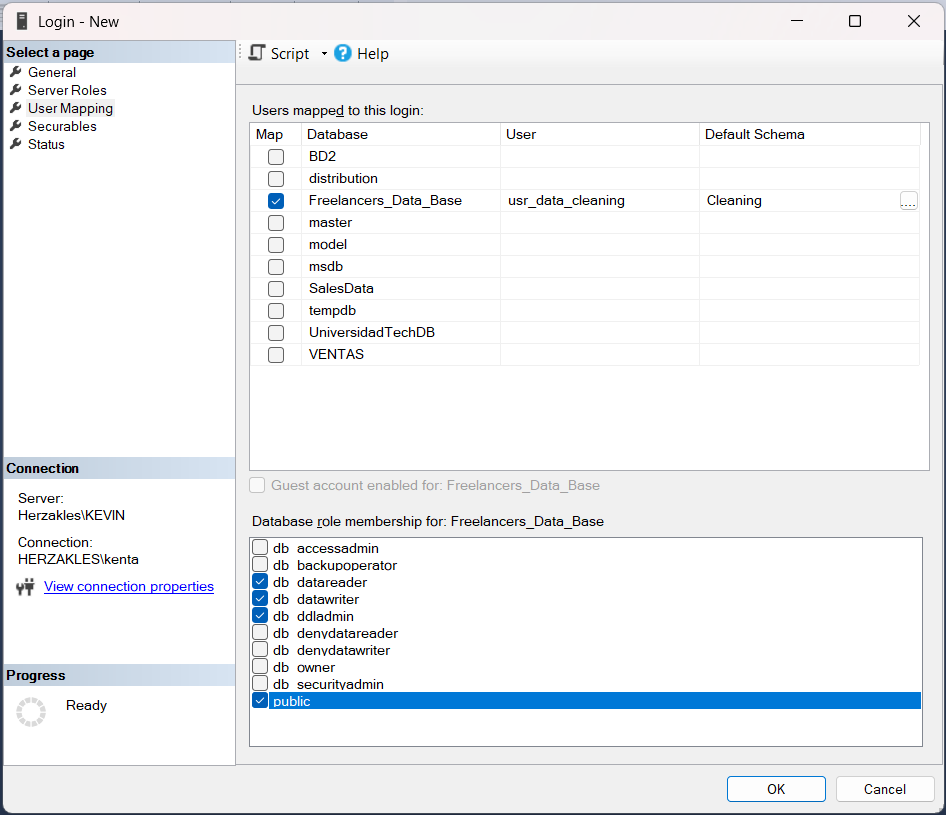

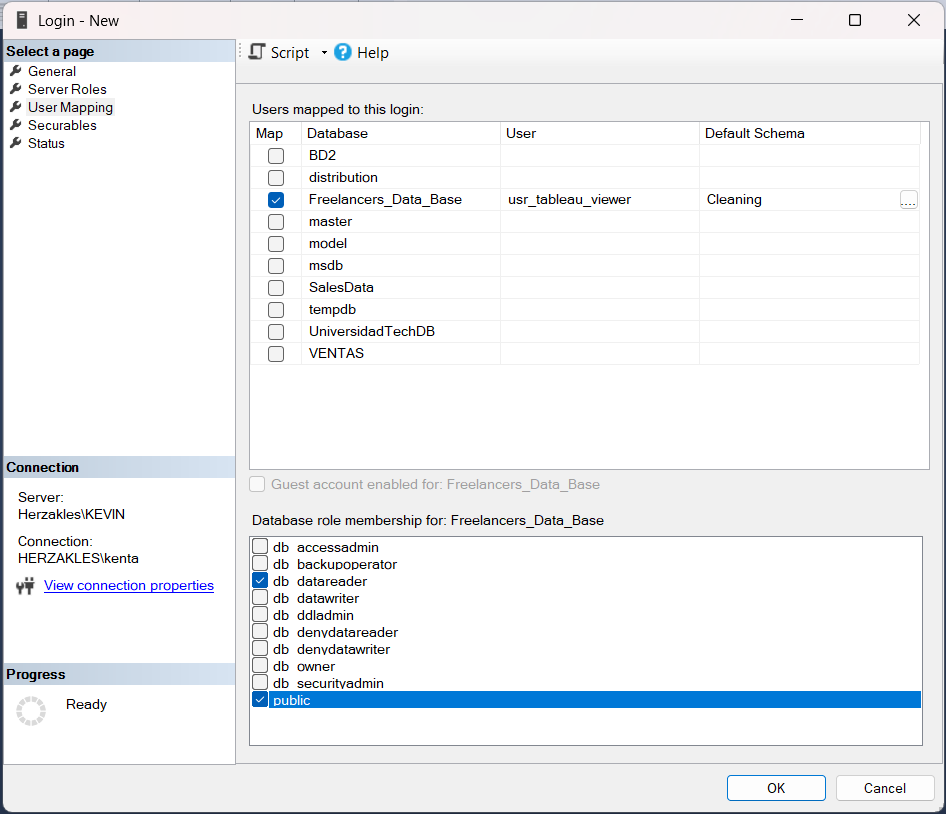

##5. Data Cleaning, Tranformation & Normalization
A comprehensive data cleaning process is performed to ensure data accuracy and consistency. Key steps include:

* Dataset Inspection & Standardization

* Value Cleaning
  * Format inconsistencies
  * Potential duplicates
  * Semantic Errors


###1. Dataset Inspection & Standarization


For this step I used this queries for each column;


```
SELECT
    COUNT(column) AS non_nulls,
    COUNT(DISTINCT column) AS distinct_values,
	MAX(column) AS MAX,
    MIN(column) AS MIN
FROM [Freelancers_Data_Base].[Cleaning].[Global_Freelancers_Dataset]
```

On this table I organized the important info we need for this step;

|COLUMN|NOT NULLS|DISTINCT|%_OF_MISSING_DATA|RANGE|EXPECTED_TYPE|
|-|-|-|-|-|-|
|[freelancer_ID]|1000|1000|-|-|VARCHAR(10)
|[name]|1000|992*|-|-|NVARCHAR(100)
|[gender]|1000|4x|-|-|CHAR(1)
|[age]|970**|41|5.5%|20-60|TINYINT
|[country]|1000|21|-|-|NVARCHAR(50)
|[language]|1000|16|-|-|NVARCHAR(50)
|[primary_skill]|1000|10|-|-|NVARCHAR(100)
|[years_of_experience]|949***|41|9.4%|0-9|TINYINT
|[hourly_rate_USD]|949***|18|17.4%|¿?x|DECIMAL(6,2)
|[rating]|899***|42|18.7%|0.0-5.0|DECIMAL(3,2)
|[is_active]|911***|8x|16.4%|-|CHAR(1)
|[client_satisfaction]|824***|81|32.5%|¿?x|TINYINT

```
Proportion of missing data:
(how much each column contributes to total missing data)
total_missing_values = 541

%_OF_MISSING_DATA = (NULLS/541)*100
```

*: This could be potentially duplicated values

**: We are just missing important values

***: NULL here could mean actual info, or we are just missing important values (since it depends on the context, on this project we will asume the second one)

x: We have format inconsistencies






###2. Value Cleaning
We won't remove any null, since there are 541 nulls and it represents removing a big portion of data we can use, instead we will explain missing values within project context.




* **Format inconsistencies**

First we will take care of the format inconsistencies we saw before

|[is_active]|[gender]|[hourly_rate_USD]|[client_satisfaction]|
|-|-|-|-|
N|f| $#| #|
True|male| #| #%|
NULL|FEMALE| USD #| NULL|  
yes|m| NULL|-|
False|
1|
Y|
0|
no|

```
SELECT DISTINCT [column]
FROM [Cleaning].[Global_Freelancers_Dataset];
```

```
UPDATE [Cleaning].[Global_Freelancers_Dataset]
SET [gender] =
    CASE
        WHEN UPPER(LTRIM(RTRIM([gender]))) IN ('F', 'FEMALE') THEN 'F'
        WHEN UPPER(LTRIM(RTRIM([gender]))) IN ('M', 'MALE')   THEN 'M'
        ELSE NULL
    END;
----------------------------------------------------------------    
UPDATE [Cleaning].[Global_Freelancers_Dataset]
SET [hourly_rate_USD] =
        REPLACE(
            REPLACE(
                REPLACE([hourly_rate_USD], 'USD', ''),
            '$', ''),
        ' ', '');    
----------------------------------------------------------------
UPDATE [Cleaning].[Global_Freelancers_Dataset]
SET [client_satisfaction] =
        REPLACE([client_satisfaction], '%', '');
----------------------------------------------------------------
UPDATE [Cleaning].[Global_Freelancers_Dataset]
SET [is_active] =
    CASE
        WHEN UPPER(LTRIM(RTRIM([is_active]))) IN ('1', 'TRUE', 'YES', 'Y') THEN 1
        WHEN UPPER(LTRIM(RTRIM([is_active]))) IN ('0', 'FALSE', 'NO', 'N') THEN 0
        ELSE NULL
    END;
```


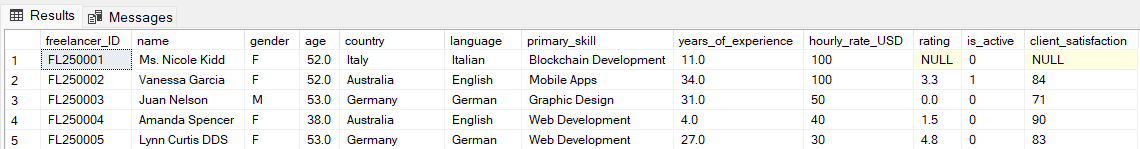

Now we need to have [age] & [years_of_experience] as TINYINT, then we can apply the right format on the other columns.



```
UPDATE [Cleaning].[Global_Freelancers_Dataset]
SET [column] = CAST(CAST([column] AS FLOAT) AS TINYINT)
WHERE TRY_CONVERT(FLOAT, [column]) IS NOT NULL;
------------------------------------------------------
ALTER TABLE [Freelancers_Data_Base].[Cleaning].[Global_Freelancers_Dataset]
ALTER COLUMN [column] data_type;
```




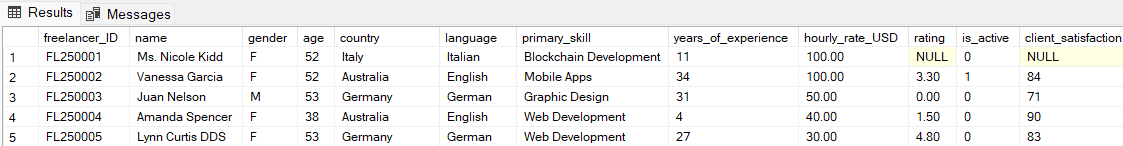

* **Potential duplicates**

We will look for duplicates within the column "name" as we asumed before.

```
WITH CTE AS (
SELECT [name], COUNT(*) AS 'COUNT'
FROM [Cleaning].[Global_Freelancers_Dataset]
GROUP BY [name]
HAVING COUNT(*) > 1
)
SELECT * FROM [Cleaning].[Global_Freelancers_Dataset] G
JOIN CTE ON G.[name] = CTE.[name]
```
This is giving us 8 different names that are duplicated, exactly what we were able to deduct before, since we had only 992 different names, however checking the ID, we can notice there are not real duplicates, just same name but different people.


* **Semantic Errors**

Finally, we will fix any semantic errors to ensure clarity at the moment of analysing the data later.

And, as we can see on the table below, only column [name] has semantics errors.

(Also, here we are asuming validation rules to explore semantic errors)

|[freelancer_ID]|[name]|[country]|[language]|[primary_skill]|
|-|-|-|-|-|
OK | Invalid_caracthers	|ARGENTINA	|AFRIKAANS	|AI
-|	OK	|AUSTRALIA	|ARABIC	|Blockchain Development
-|Title_or_Sufix	|BRAZIL	|DUTCH	|Cybersecurity
-|	-	|CANADA	|ENGLISH	|Data Analysis
-|	-	|CHINA	|FRENCH	|DevOps
-|	-	|EGYPT	|GERMAN	|Graphic Design
-|	-	|FRANCE	|HINDI	|Machine Learning
-|	-	|GERMANY	|INDONESIAN	|Mobile Apps
-|	-	|INDIA	|ITALIAN	|UI/UX Design
-|	-	|INDONESIA	|JAPANESE	|Web Development
-|	-	|ITALY	|KOREAN	|-
-|  -	|JAPAN	|MANDARIN	|-
-|	-	|MEXICO	|PORTUGUESE	|-
-|	-	|NETHERLANDS	|RUSSIAN	|-
-|	-	|RUSSIA	|SPANISH	|-
-|	-	|SOUTH AFRICA	|TURKISH	|-
-|	-	|SOUTH KOREA	|-	|-
-|	-	|SPAIN	|-	|-
-|	-	|TURKEY	|-	|-
-|	-	|UNITED KINGDOM	|-	|-
-|	-	|UNITED STATES	|-	|-


```
-- To check semantic validation on [freelancer_ID]

WITH CTE AS (
SELECT
    CASE
        WHEN LEN([freelancer_ID]) <> 8 THEN 'incorrect len'
        WHEN LEFT([freelancer_ID], 2) <> 'FL' THEN 'invalid prefix'
        WHEN TRY_CONVERT(INT, RIGHT([freelancer_ID], 4)) IS NULL THEN 'no numeric'
        ELSE 'OK'
    END AS semantic_validation
FROM [Cleaning].[Global_Freelancers_Dataset]
)
SELECT semantic_validation, COUNT(*) AS 'COUNT' FROM CTE
GROUP BY semantic_validation;
```
```
-- To check semantic validation on [name]
WITH CTE AS (
    SELECT
        [name],
        CASE
            WHEN [name] LIKE '%[0-9]%' THEN 'Numbers'
            WHEN [name] LIKE '%[^a-zA-Z ]%' THEN 'Invalid_caracthers'
            WHEN [name] LIKE 'Ms.%'
              OR [name] LIKE 'Mr.%'
              OR [name] LIKE 'Mrs.%'
              OR [name] LIKE 'Dr.%'
              OR [name] LIKE '% DDS'
              OR [name] LIKE '% MD'
            THEN 'Title_or_Sufix'
            WHEN LEN(LTRIM(RTRIM([name]))) - LEN(REPLACE([name], ' ', '')) < 1
            THEN 'One_Word'
            WHEN [name] LIKE '%  %'
            THEN 'Double_Space'
            ELSE 'OK'
        END AS SemanticValidation
    FROM [Cleaning].[Global_Freelancers_Dataset]
)
SELECT
    SemanticValidation,
    COUNT(*) AS Total
FROM CTE
GROUP BY SemanticValidation;

```
```
-- To check duplicated values on [country] & [language]

SELECT UPPER(LTRIM(RTRIM(column))), COUNT(column) AS 'COUNT'
FROM [Cleaning].[Global_Freelancers_Dataset]
GROUP BY column
HAVING COUNT(*) > 1
ORDER BY column
```
```
-- To check duplicated values on [primary_skill]

SELECT DISTINCT [primary_skill], COUNT(*) AS 'COUNT'
FROM [Cleaning].[Global_Freelancers_Dataset]
GROUP BY [primary_skill]
ORDER BY [primary_skill];
```

So, now we can see the only problem is Invalid_caracthers & Title_or_Sufix on the column [name], but I will work only on deterministic patterns like Title_or_Sufix, while other anomalies (Invalid_caracthers) should be reported for review to preserve data integrity.

```
--To remove Title_or_Sufix from [name]

UPDATE [Cleaning].[Global_Freelancers_Dataset]
SET [name] = LTRIM(RTRIM(
        REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE([name],
            'Ms. ', ''),
            'Mr. ', ''),
            'Mrs. ', ''),
            'Dr. ', ''),
            ' DDS', ''),
            ' MD', '')
));
```

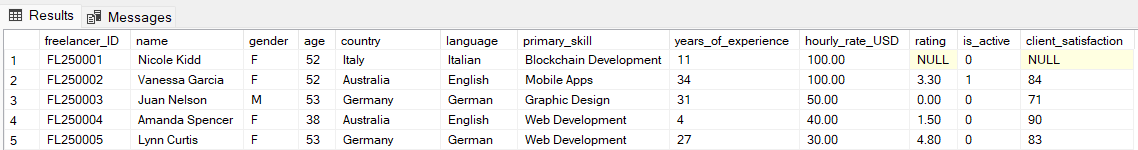

##6. Exploratory PowerBI Analysis


Lets take a look into some statistics and visualizations

|COLUMN|NOT NULLS|DISTINCT|%_OF_MISSING_DATA|RANGE|DATA_TYPE|
|-|-|-|-|-|-|
|[freelancer_ID]|1000|1000|-|-|Identifier (ID)
|[name]|1000|992|-|-|Text / String
|[gender]|1000|2|-|-|Categorical – Nominal
|[age]|970*|41|5.5%|20-60|Numerical – Discrete
|[country]|1000|21|-|-|Categorical – Nominal
|[language]|1000|16|-|-|Categorical – Nominal
|[primary_skill]|1000|10|-|-|Categorical – Nominal
|[years_of_experience]|949*|41|9.4%|0-9|Numerical – Discrete
|[hourly_rate_USD]|949*|6|17.4%|20.00-100.00|Numerical – Continuous
|[rating]|899*|42|18.7%|0.0-5.0|Numerical – Ordinal
|[is_active]|911*|2|16.4%|-|Binary
|[client_satisfaction]|824*|41|32.5%|60-100|Numerical – Ordinal

*; We have 541 NULLS in total, due to a problem collecting data, but we will try to explore if there is information we can get from that.



Lets connect SQL Server to Power BI, to use the data base:

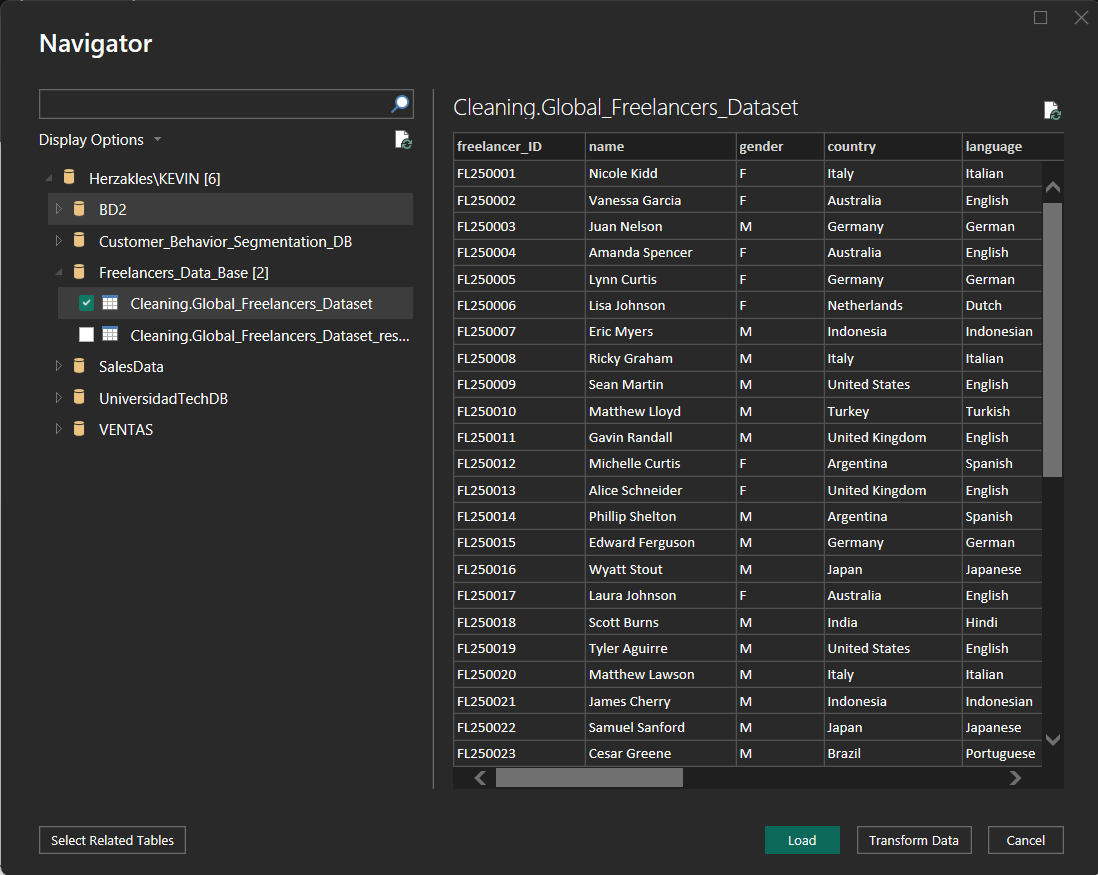

###1. Categorical vs Numerical
|VS|Insight|
|-|-|
gender vs age | Is there a difference in average age by gender?
country vs hourly_rate_USD | Which countries have the highest tariffs?
primary_skill vs years_of_experience | Which skills are most concentrated in seniority?


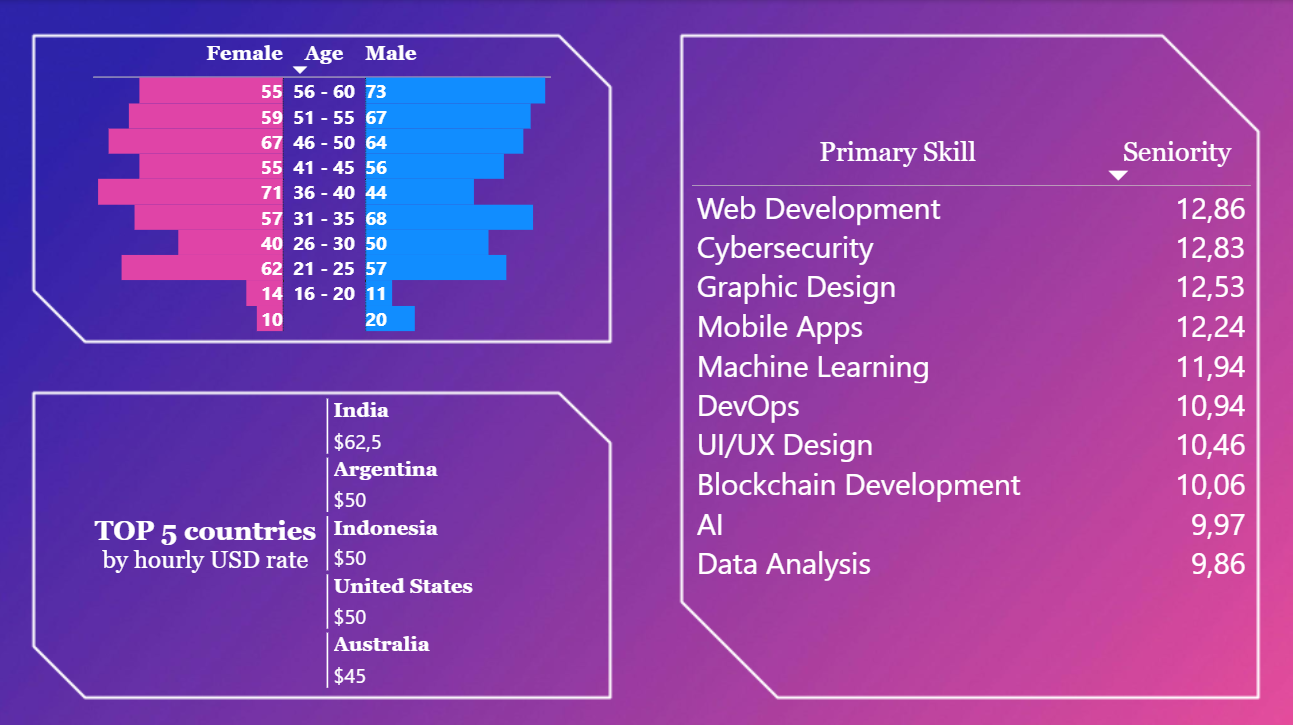

###2. Numerical vs Numerical
|VS|Insight|
|-|-|
age vs hourly_rate_USD | Does the older you are, the higher the price?
years_of_experience vs rating | Does experience improve perceived quality?
client_satisfaction vs hourly_rate_USD | Greater satisfaction → higher price?

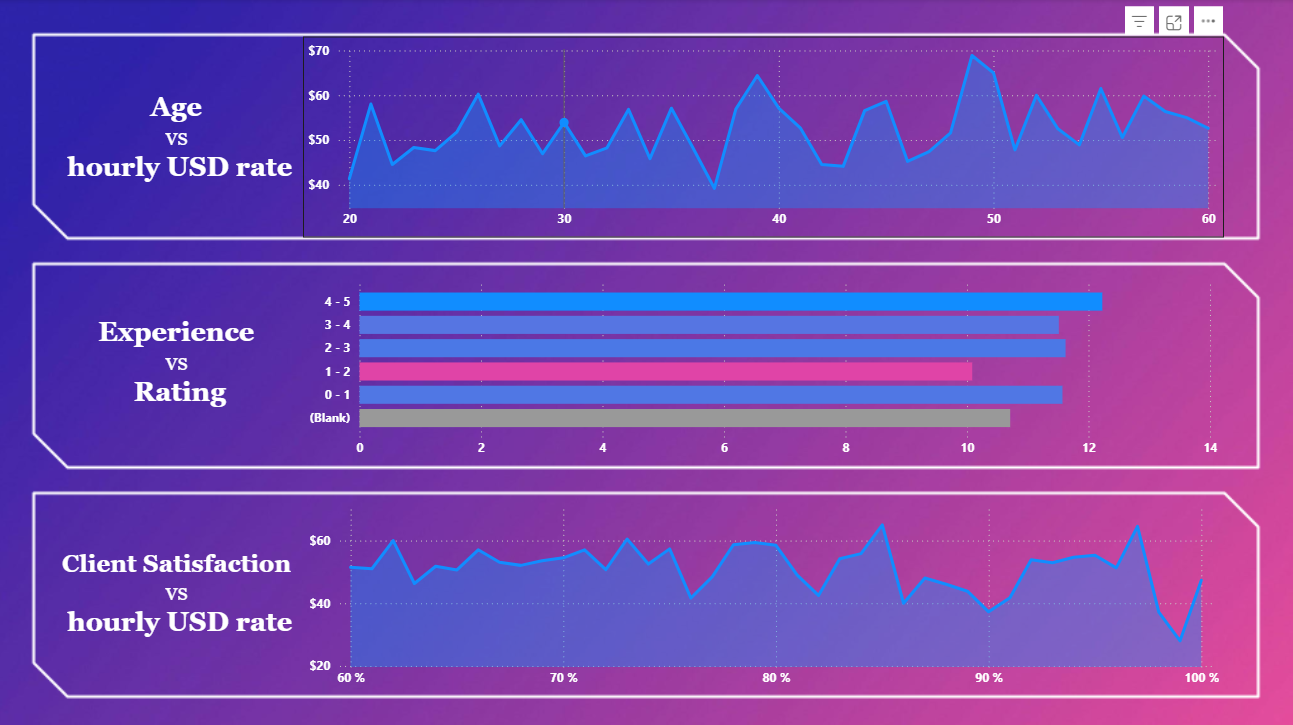

###3. Categorical vs Categorical

|VS|Insight|
|-|-|
gender vs primary_skill | What skills are predominant by gender?
country vs years_of_experience | Seniority-region relationship?

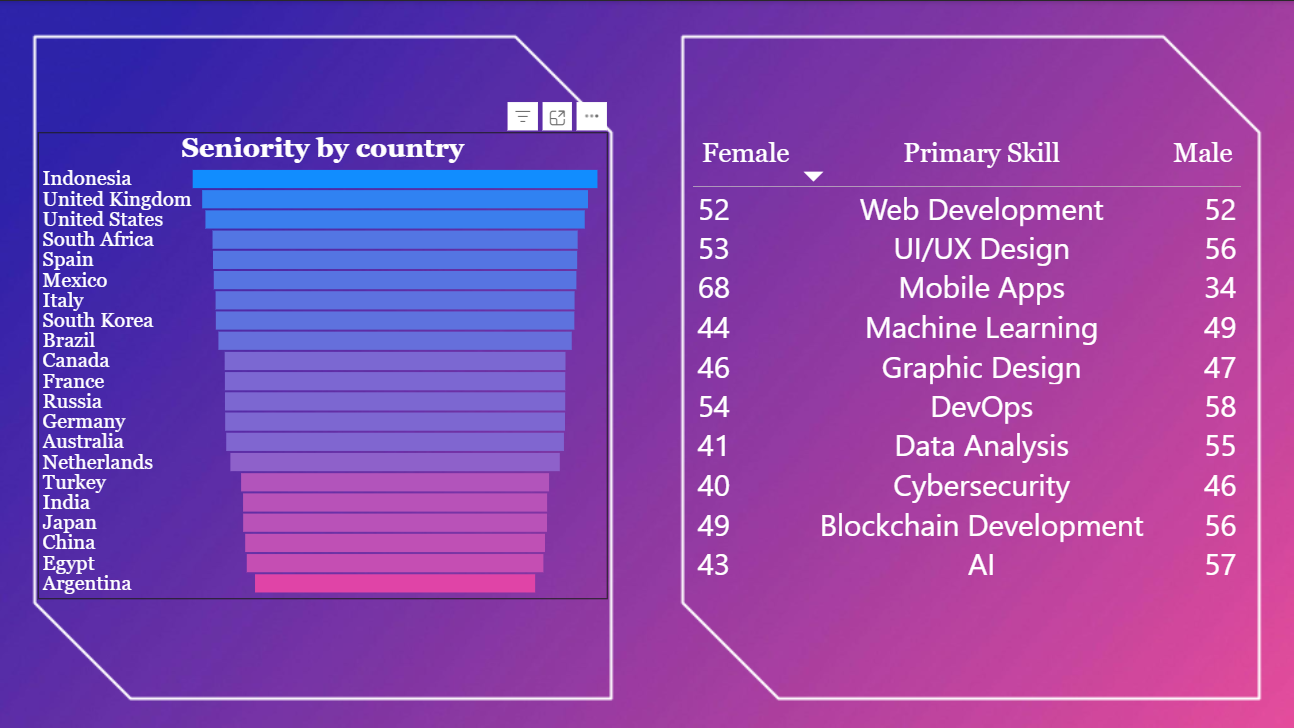

## Key Insights
- Identified and resolved duplicates, missing fields, and inconsistent formats.  
- Standardized data for accurate analysis and visualization.  


## Impact
- Enables reliable reporting and data-driven decision-making.  
- Demonstrates practical skills in SQL, data cleaning, and preparing dashboards.